
# Predict Local Spatial Frequency with a TensorFlow/Keras Model (Multi‑Output)

This notebook reproduces **Copy_of_testMultipleResponsesPredictUsingML.asv** but using a
**TensorFlow/Keras** multi-output regression model. It reads the model paths from an Excel DB row,
builds features on sliding patches, calculates features and predicts `[w, φx, φy, θ]` maps, and draws quick diagnostics.

68 LENSPMD25 INFORME-OM4M007 medida spatial freqs using ML

**Conda enviroment:**

run conda activate LENSPMD25-base310 

if not present create enviroment using yml file



In [1]:
# ---
# ✅ Colab bootstrap for LensPMD
# How to open in Colab:
# 1) Clone the LensPMD repo into Google Drive.
# 2) In Drive (web), right-click the notebook → “Open with” → “Google Colab”.
# 3) Run this cell to mount Drive, set the working directory, and verify required paths.
# ---

import os
from pathlib import Path

# === Detect Colab =============================================================
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

print(f"Running in Colab? {IN_COLAB}")

# === Setup when in Colab ======================================================
if IN_COLAB:
    from google.colab import drive  # type: ignore
    DRIVE_MOUNT_POINT = "/content/drive"
    PROJECT_REL_PATH = "MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/Python_src"
    REQUIRED_PATH = "/content/drive/MyDrive/Colab Notebooks/68_LensPMD25_INFORME-OM4M007/local_data"

    # Mount Google Drive
    drive.mount(DRIVE_MOUNT_POINT, force_remount=True)

    # Set working directory
    project_path = Path(DRIVE_MOUNT_POINT) / PROJECT_REL_PATH
    if not project_path.exists():
        raise FileNotFoundError(f"❌ Project directory not found: {project_path}")

    os.chdir(project_path)
    print("✅ Working Directory:", Path.cwd())

    # Verify required local_data folder exists
    local_data_path = Path(REQUIRED_PATH)
    if not local_data_path.exists():
        raise FileNotFoundError(
            f"❌ Required directory not found: {local_data_path}\n"
            "Please ensure 'local_data' exists in the LensPMD folder in your Drive."
        )

    print("✅ Required folder found:", local_data_path)
    print("📂 Files in Working Directory:", os.listdir())

else:
    print("Not running in Colab — skipping Drive mount and WD setup.")
    print("Current Working Directory:", Path.cwd())


Running in Colab? False
Not running in Colab — skipping Drive mount and WD setup.
Current Working Directory: c:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\Python_src


In [2]:

# --- Setup ---
# %pip install tensorflow==2.16.* scikit-learn==1.4.* pandas openpyxl matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ml_spatialfreq_utils import (
    TrainedModelTF, DBInfo, calc_spatial_freqs_supervised_regression_batch, synth_fringe, peaks
)

plt.rcParams["figure.figsize"] = (5.5, 4.2)


In [3]:

# --- Resolve model paths from the DB Excel ---
rootFolderDB = Path('../local_data/ML_Models')              # Adjust if needed
db_name = 'DB-trainingSets-OM4M007.xlsx'        # Same as MATLAB
db_sheet = 'Sheet1'                             
trainingSet_Idx = 16                              # 1-based row index

db_path = rootFolderDB / db_name
print("Reading DB:", db_path.resolve())
db_tb = pd.read_excel(db_path, sheet_name=db_sheet)

row_idx = trainingSet_Idx - 1
assert 0 <= row_idx < len(db_tb), "trainingSet_Idx out of range"

row = db_tb.iloc[row_idx].to_dict()

# Expected columns for Python artifacts (preferred). If missing, you can fill them below.
kerasModelPath = rootFolderDB / row.get('trainedModel')
scalerPath     = rootFolderDB / row.get('scaler')
featureMetadataPath  = rootFolderDB / row.get('feature_metadata')
featureName    = row.get('featureName')
patch_NR       = int(row.get('patch_NR'))
patch_NC       = int(row.get('patch_NC'))

print("kerasModel Name:", kerasModelPath)
print("scaler name    :", scalerPath)
print("feature_metadata name      :", featureMetadataPath)
print("feature Name   :", featureName, " patch:", patch_NR, "x", patch_NC)


Reading DB: C:\user\AQ_SCC\68_LensPMD25_INFORME-OM4M007\local_data\ML_Models\DB-trainingSets-OM4M007.xlsx
kerasModel Name: ..\local_data\ML_Models\trainedModel_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.keras
scaler name    : ..\local_data\ML_Models\scaler_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.pkl
feature_metadata name      : ..\local_data\ML_Models\feature_metadata_14-10-2025_DB_feature_projected_DFT_15x15_GVN-0_NS-16001_13-Oct-2025.json
feature Name   : feature_projected_DFT  patch: 15 x 15


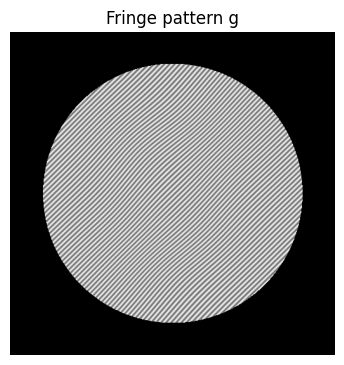

In [4]:

# --- Build or load a test fringe pattern (like the MATLAB script) ---
NR, NC = 511, 512
y, x = np.mgrid[0:NR, 0:NC]
y=y-0.5*NR; x=x-0.5*NC
R=0.4*NR

# M_ROI = np.ones_like(g, dtype=bool)  # full image ROI
M_ROI = np.abs(x + 1j*y)<R

w0_x, w0_y = np.pi/4, np.pi/4
phi = peaks(NR, NC)
g = synth_fringe(NR, NC, w0_x, w0_y, phi, modulation=50, background=128, noise_std=2)

plt.figure(); plt.imshow(g*M_ROI, cmap='gray'); plt.title('Fringe pattern g'); plt.axis('off'); plt.show()



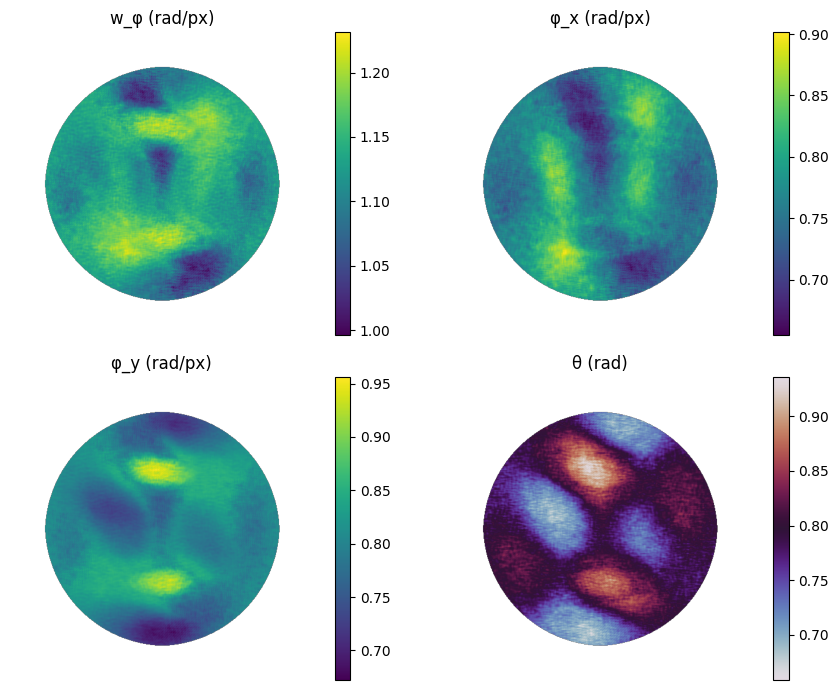

In [5]:

# --- Predict spatial-frequency maps ---
dbi = DBInfo(featureName=str(featureName), patch_NR=int(patch_NR), patch_NC=int(patch_NC))
tm = TrainedModelTF(model_path=kerasModelPath, scaler_path=scalerPath, meta_path=featureMetadataPath, DB_info=dbi)

w_phi, phi_x, phi_y, theta, QM, M_proc = calc_spatial_freqs_supervised_regression_batch(
    g, tm, feature_name=str(featureName), M_ROI=M_ROI
)

# Masks
MNan = M_proc.copy().astype(float)
MNan[~QM] = np.nan

# Display predictions (where valid)
fig, axs = plt.subplots(2,2, figsize=(9,7))
im = axs[0,0].imshow(w_phi*MNan, cmap='viridis'); axs[0,0].set_title('w_φ (rad/px)'); plt.colorbar(im, ax=axs[0,0])
im = axs[0,1].imshow(phi_x*MNan, cmap='viridis'); axs[0,1].set_title('φ_x (rad/px)'); plt.colorbar(im, ax=axs[0,1])
im = axs[1,0].imshow(phi_y*MNan, cmap='viridis'); axs[1,0].set_title('φ_y (rad/px)'); plt.colorbar(im, ax=axs[1,0])
im = axs[1,1].imshow(theta*MNan, cmap='twilight'); axs[1,1].set_title('θ (rad)'); plt.colorbar(im, ax=axs[1,1])
for ax in axs.ravel(): ax.axis('off')
plt.tight_layout(); plt.show()


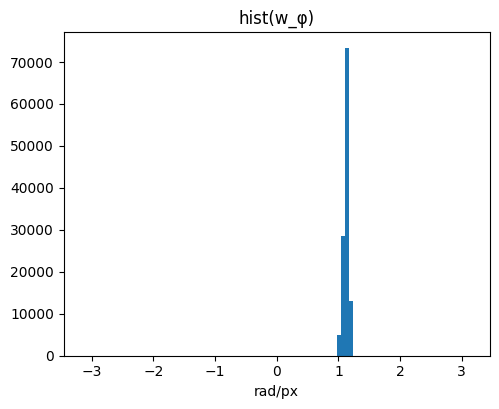

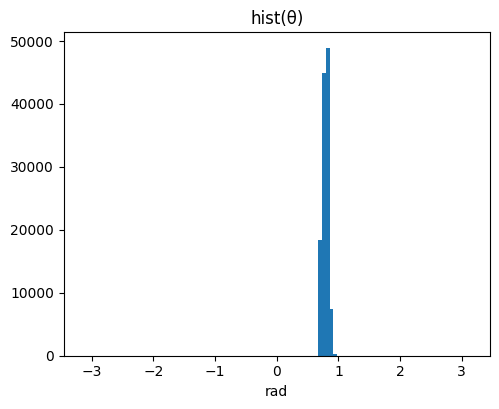

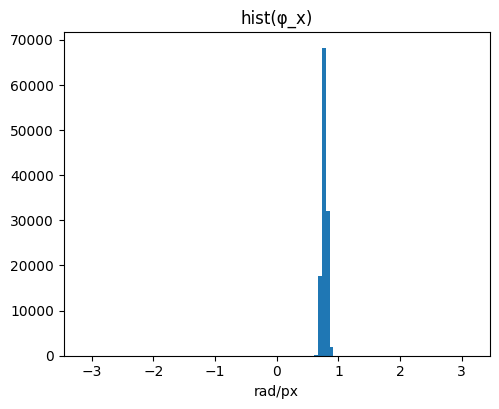

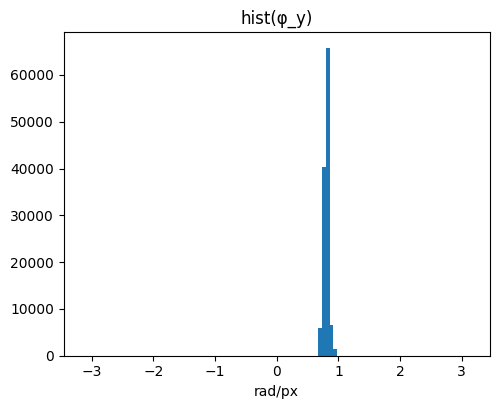

In [6]:

# --- Histograms on valid pixels (as in MATLAB) ---
mask = QM
edges1 = np.linspace(-np.pi, np.pi, 100)

plt.figure(); plt.hist(w_phi[mask], bins=edges1); plt.title('hist(w_φ)'); plt.xlabel('rad/px'); plt.show()
plt.figure(); plt.hist(theta[mask], bins=edges1); plt.title('hist(θ)');   plt.xlabel('rad');    plt.show()
plt.figure(); plt.hist(phi_x[mask], bins=edges1); plt.title('hist(φ_x)'); plt.xlabel('rad/px'); plt.show()
plt.figure(); plt.hist(phi_y[mask], bins=edges1); plt.title('hist(φ_y)'); plt.xlabel('rad/px'); plt.show()
